# Training of Classifiers and Visualization of Results

In this first tutorial we aim to show some basic functionality of SecML.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/01-Training.ipynb)

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://github.com/pralab/secml

## Creation and visualization of a simple 2D dataset

The first step is loading the dataset. We are going to use a simple toy dataset
 consisting of 3 clusters of points, normally distributed.

Each dataset of SecML is a `CDataset` object, consisting of `dataset.X`
 and `dataset.Y`, where the samples and the corresponding labels are stored,
 respectively.

In [2]:
random_state = 999

n_features = 2  # Number of features
n_samples = 1250  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.8  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

2024-11-30 14:16:28,483 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2024-11-30 14:16:28,483 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2024-11-30 14:16:28,503 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2024-11-30 14:16:28,503 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2024-11-30 14:16:28,523 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2024-11-30 14:16:28,523 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2024-11-30 14:16:28,532 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2024-11-30 14:16:28,532 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2024-11-30 14:16:28,539 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2024-11-30 14:16:28,539 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2024-11-30 14:16:28,545 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs
2024-11-30 14:16:28,545 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2024-11-30 14:16:28,549 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data
2024-11-30 14:16:28,549 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


The dataset will be split in *training* and *test*, and normalized
in the standard interval `[0, 1]` with a *min-max* normalizer.

In [3]:
n_tr = 1000  # Number of training set samples
n_ts = 250  # Number of test set samples

# Split in training and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

Let's visualize the dataset in a 2D plane.

The three clusters are clearly separable and normalized as we required.

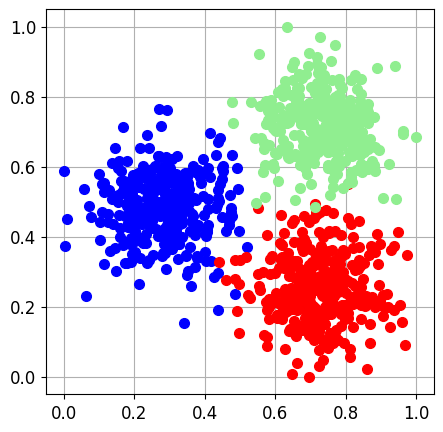

In [4]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=5, height=5)

# Convenience function for plotting a dataset
fig.sp.plot_ds(tr)

fig.show()

## Training of classifiers

Now we can train a **non-linear one-vs-all Support Vector Machine (SVM)**,
 using a **Radial Basis Function (RBF)** kernel for embedding.

We will evaluate the best training parameters through a *3-Fold Cross-Validation*
 procedure, using the accuracy as the performance metric. Each classifier has an
 integrated routine, `.estimate_parameters()` which estimates the best parameters
 on the given training set.

In [5]:
# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF
svm = CClassifierSVM(kernel=CKernelRBF())

# Parameters for the Cross-Validation procedure
xval_params = {'C': [0.1, 1, 10], 'kernel.gamma': [1, 10, 100]}

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Select and set the best training parameters for the classifier
print("Estimating the best training parameters...")
best_params = svm.estimate_parameters(
    dataset=tr,
    parameters=xval_params,
    splitter=xval_splitter,
    metric=metric,
    perf_evaluator='xval'
)

print("The best training parameters are: ",
      [(k, best_params[k]) for k in sorted(best_params)])

# We can now fit the classifier
svm.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = svm.predict(ts.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Estimating the best training parameters...
The best training parameters are:  [('C', 1), ('kernel.gamma', 10)]
Accuracy on test set: 98.80%


## Visualization of the decision regions of the classifiers

Once the classifier is trained, we can visualize the *decision regions*
 over the entire feature space.

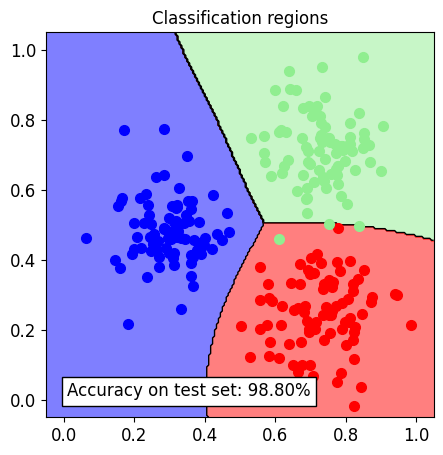

In [6]:
fig = CFigure(width=5, height=5)

# Convenience function for plotting the decision function of a classifier
fig.sp.plot_decision_regions(svm, n_grid_points=200)

fig.sp.plot_ds(ts)
fig.sp.grid(grid_on=False)

fig.sp.title("Classification regions")
fig.sp.text(0.01, 0.01, "Accuracy on test set: {:.2%}".format(acc),
            bbox=dict(facecolor='white'))
fig.show()

## Training other classifiers

Now we can repeat the above process for other classifiers available in SecML.
We are going to use a `namedtuple` for easy storage of objects and parameters.

Binary classifiers like `CClassifierSGD` can be extended to multiclass one-vs-all schemes using `CMulticlassClassifierOVA`.

*Please note that parameters estimation may take a while (up to a few minutes)
 depending on the machine the script is run on.*


Estimating the best training parameters of SVM Linear ...
The best parameters for 'SVM Linear' are:  [('C', 1)]
Training of SVM Linear ...
Classifier: SVM Linear	Accuracy: 99.20%

Estimating the best training parameters of SVM RBF ...
The best parameters for 'SVM RBF' are:  [('C', 1), ('kernel.gamma', 10)]
Training of SVM RBF ...
Classifier: SVM RBF	Accuracy: 98.80%

Estimating the best training parameters of Logistic (SGD) ...
The best parameters for 'Logistic (SGD)' are:  [('alpha', 1e-06)]
Training of Logistic (SGD) ...
Classifier: Logistic (SGD)	Accuracy: 98.80%

Estimating the best training parameters of kNN ...
The best parameters for 'kNN' are:  [('n_neighbors', 10)]
Training of kNN ...
Classifier: kNN	Accuracy: 98.80%

Estimating the best training parameters of Decision Tree ...
The best parameters for 'Decision Tree' are:  [('max_depth', 3)]
Training of Decision Tree ...
Classifier: Decision Tree	Accuracy: 99.20%

Estimating the best training parameters of Random Forest ...
T

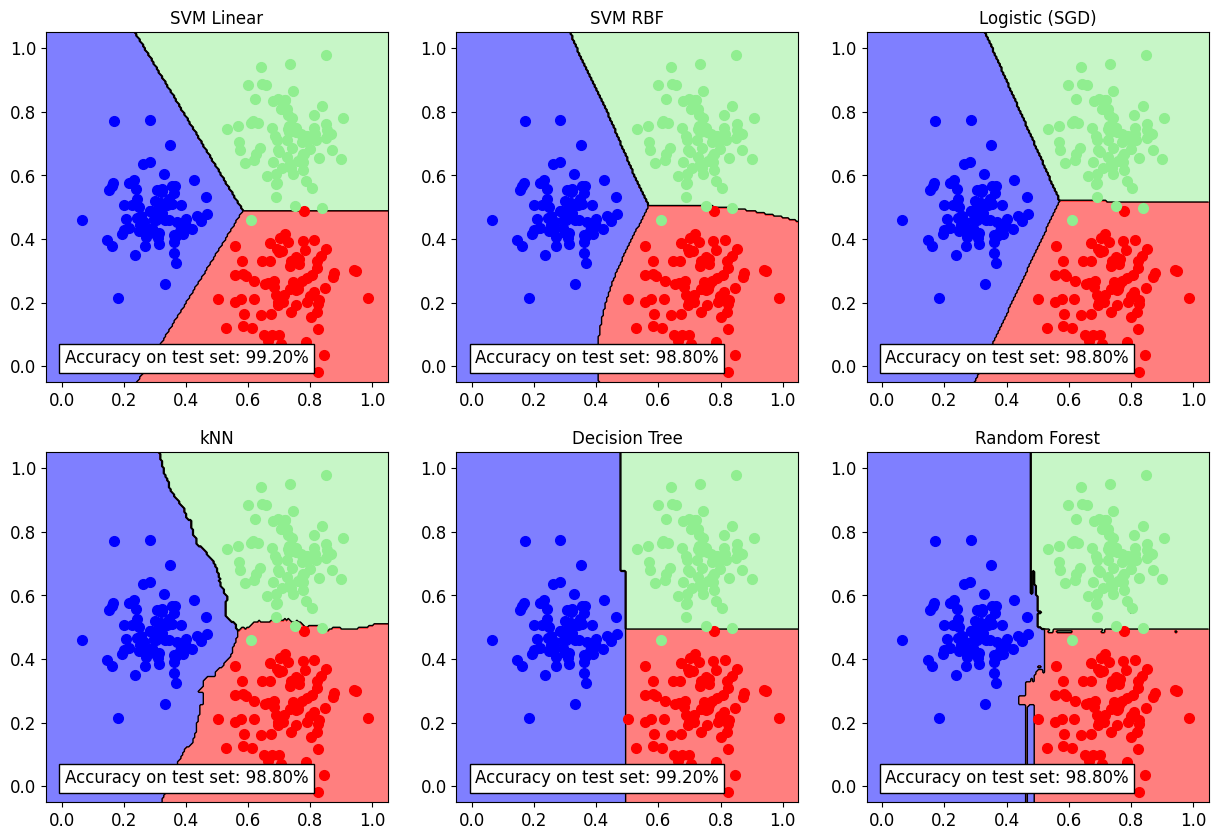

In [7]:
from collections import namedtuple
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')

# Binary classifiers
from secml.ml.classifiers import CClassifierSGD
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
# Natively-multiclass classifiers
from secml.ml.classifiers import CClassifierSVM, CClassifierKNN, CClassifierDecisionTree, CClassifierRandomForest

clf_list = [
    CLF(
        clf_name='SVM Linear',
        clf=CClassifierSVM(),
        xval_parameters={'C': [0.1, 1, 10]}),
    CLF(clf_name='SVM RBF',
        clf=CClassifierSVM(kernel='rbf'),
        xval_parameters={'C': [0.1, 1, 10],  'kernel.gamma': [1, 10, 100]}),
    CLF(clf_name='Logistic (SGD)',
        clf=CClassifierMulticlassOVA(
            CClassifierSGD, regularizer='l2', loss='hinge',
            random_state=random_state),
        xval_parameters={'alpha': [1e-7, 1e-6, 1e-5]}),
    CLF(clf_name='kNN',
        clf=CClassifierKNN(),
        xval_parameters={'n_neighbors': [5, 10, 20]}),
    CLF(clf_name='Decision Tree',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [1, 3, 5]}),
    CLF(clf_name='Random Forest',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [10, 20, 30]}),
]

from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

fig = CFigure(width=5 * len(clf_list) / 2, height=5 * 2)

for i, test_case in enumerate(clf_list):

    clf = test_case.clf
    xval_params = test_case.xval_parameters

    print("\nEstimating the best training parameters of {:} ..."
          "".format(test_case.clf_name))

    best_params = clf.estimate_parameters(
        dataset=tr, parameters=xval_params, splitter=xval_splitter,
        metric='accuracy', perf_evaluator='xval')

    print("The best parameters for '{:}' are: ".format(test_case.clf_name),
          [(k, best_params[k]) for k in sorted(best_params)])

    print("Training of {:} ...".format(test_case.clf_name))
    clf.fit(tr.X, tr.Y)

    # Predictions on test set and performance evaluation
    y_pred = clf.predict(ts.X)
    acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

    print("Classifier: {:}\tAccuracy: {:.2%}".format(test_case.clf_name, acc))

    # Plot the decision function
    from math import ceil
    # Use `CFigure.subplot` to divide the figure in multiple subplots
    fig.subplot(2, int(ceil(len(clf_list) / 2)), i + 1)

    fig.sp.plot_decision_regions(clf, n_grid_points=200)

    fig.sp.plot_ds(ts)
    fig.sp.grid(grid_on=False)

    fig.sp.title(test_case.clf_name)
    fig.sp.text(0.01, 0.01, "Accuracy on test set: {:.2%}".format(acc),
                bbox=dict(facecolor='white'))

fig.show()